# A tour of classification metrics

Author: [Thomas Moreau](https://tommoral.github.io/)

In [35]:
# Plot imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#  Evaluating the model quality


For supervised learning algorithms, where one wants to predict a target $y$ from a given input $X$, most models are derived by defining a loss function. For parametric model $\widehat y = f_\theta$, the goal of supervised learning can be written as
$$
    \min_\theta\frac{1}{N}\sum_i\ell(y_i, f_\theta(X_i))]
$$
for a well chosen loss function $\ell$ which measure the distance between the predicted $f_\theta(X)$ and the true target $y$.

To **evaluate the model**, we have seen yesterday that a first way was to use a set of unseen data -- called *test set* or *validation set* -- to estimate the generalization performances of the model. This generalization can be quantified by computed the same loss used for training. However, these loss are not always very informative as there value can be hard to interpret (scale, imbalance, $\dots$).

To improve the comprehension of the performance of the model, it is possible to use a different evaluation metric to highlight the properties of the prediction. We review bellow classical metric choices.

The simple way to use a scoring metric during cross-validation is via the scoring parameter of [`sklearn.model_selection.cross_validate`.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate).
We will see now different metrics to evaluate the models.

## Regression Metrics


### Mean Squared Error (MSE)

The most classical way to measure distance is to use the the $\ell_2$-norm. The MSE metric simply computes the average $\ell_2$-distance between the prediction and the true target, *i.e.*
$$
    MSE(y, \widehat y) = \frac{1}{N}\sum_{i=1}^N (y_i - \widehat y_i)^2
$$

While this metric can be useful to evaluate linear regression models with gaussian noise, it can fail to distinguish between good and bad cases when the assumptions of the linear model are broken. This is illustrated with the [Anscombe Quartet](https://fr.wikipedia.org/wiki/Quartet_d%27Anscombe), where 4 very different datasets have the same MSE error for linear regression. Note that as the `LinearRegression` fo scikit-learn is an Ordinary Least Squares, the reported MSE is the lowest one that can be achieved for a linear model.


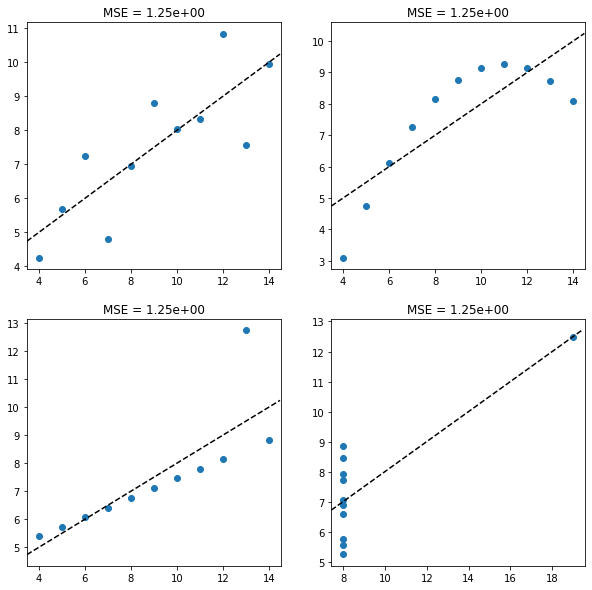

In [36]:
import json

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

with open('anscombe_quartet.json') as f:
    anscombe_quartet = np.array(json.load(f))
    
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for data, ax in zip(anscombe_quartet, axes.ravel()):
    x, y = data[0], data[1]
    reg.fit(x[:, None], y)
    y_pred = reg.predict(x[:, None])
    ax.scatter(x, y)
    
    xlim = ax.get_xlim()
    t = np.arange(*xlim)
    ax.plot(t, reg.coef_ * t + reg.intercept_, 'k--')
    ax.set_xlim(xlim)
    
    ax.set_title(f"MSE = {mean_squared_error(y_pred, y):.2e}")

This metric can also be rescaled to take into account the variance of the original $y$. This is called the Explained Variance:
$$
    Var_{explained}(y, \widehat y) = \frac{\sum_{i=1}^N (y_i - \widehat y_i)^2
                                         }{\sum_{i=1}^N (y_i - \bar y)^2}
                                   = \frac{MSE(y, \widehat y)}{Var(y)}
    \enspace ,
$$
where $\bar y$ is the mean value of $y$. This value is also linked to the Determination coefficient ($R^2$) as $R^2 = 1 - Var_{explained}$.

In [37]:
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


boston = datasets.load_boston()

# Shuffle the data
data, target = shuffle(boston.data, boston.target, random_state=0)

regressor = RandomForestRegressor(n_estimators=10)

print("Explained variance:", cross_val_score(regressor, data, target, cv=5))

Explained variance: [0.71864446 0.89469349 0.82077343 0.67802143 0.91425822]


Explained variance is convienent because it has a natural scaling: 1 is
perfect prediction, and 0 is around chance

Now let us see which houses are easier to predict. Feature 3 tells us whether the house is along Charles river or not.

In [38]:
print("Along Charles River:",
      cross_val_score(regressor, data[data[:, 3] == 1],
                      target[data[:, 3] == 1], cv=5))
print("Not Along Charles River:",
      cross_val_score(regressor, data[data[:, 3] == 0],
                      target[data[:, 3] == 0], cv=5))

Along Charles River: [ 0.33101508  0.41080263 -7.39651259  0.78646999  0.82778011]
Not Along Charles River: [0.74829615 0.88675782 0.90147834 0.76357914 0.90573341]


In [39]:
print("Along Charles River:",
      cross_val_score(regressor, data[data[:, 3] == 1],
                      target[data[:, 3] == 1], cv=5,
                      scoring='neg_mean_squared_error'))
print("Not Along Charles River:",
      cross_val_score(regressor, data[data[:, 3] == 0],
                      target[data[:, 3] == 0], cv=5,
                      scoring='neg_mean_squared_error'))

Along Charles River: [-120.04147143  -42.36201429  -51.49944286  -25.78804286  -28.48217143]
Not Along Charles River: [-16.63602737  -8.69026277  -7.04398936 -18.09329149  -8.17127021]


### Mean Absolute Error (MAE)

Another popular metric for regression is to use the $\ell_1$-norm to quantify the difference between the predictions and the target *i.e.*
$$
    MAE(y, \widehat y) = \frac{1}{N}\sum_{i=1}^N |y_i - \widehat y_i| \enspace .
$$
This metric is more balanced than the MSE. Indeed, MSE tend to lower the importance of small deviation while it increase the one of the large deviation. It can be seen with the previous example.

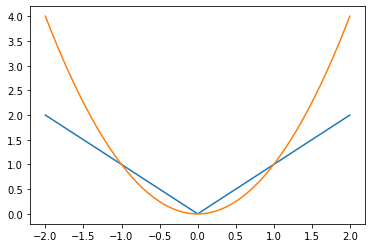

In [40]:
t = np.linspace(-2, 2, 10000)
plt.plot(t, abs(t))
plt.plot(t, t**2)

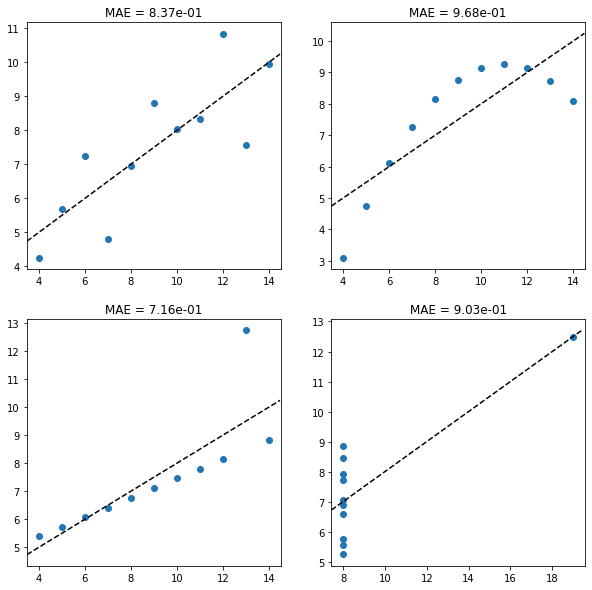

In [41]:
from sklearn.metrics import mean_absolute_error

reg = LinearRegression()
    
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for data, ax in zip(anscombe_quartet, axes.ravel()):
    x, y = data[0], data[1]
    reg.fit(x[:, None], y)
    y_pred = reg.predict(x[:, None])
    ax.scatter(x, y)
    
    xlim = ax.get_xlim()
    t = np.arange(*xlim)
    ax.plot(t, reg.coef_ * t + reg.intercept_, 'k--')
    ax.set_xlim(xlim)
    ax.set_title(f"MAE = {mean_absolute_error(y_pred, y):.2e}")

In particular, the MAE metric is less sensible to outliers. For the third example, we can see that the MAE is lower of the line fitted without the outlier while the MSE is larger.

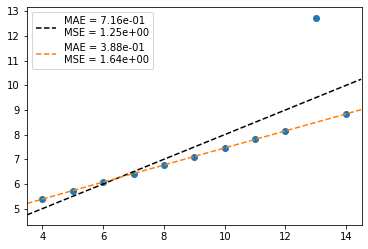

In [42]:
x, y = anscombe_quartet[2]

#
reg.fit(x[:, None], y)
y_pred = reg.predict(x[:, None])

plt.scatter(x, y)

xlim = plt.xlim()
t = np.arange(*xlim)
plt.plot(t, reg.coef_ * t + reg.intercept_, 'k--',
        label=f"MAE = {mean_absolute_error(y_pred, y):.2e}\n"
              f"MSE = {mean_squared_error(y_pred, y):.2e}")


# Remove the out of line sample and fit another regression model
x_clean, y_clean = np.r_[x[:2], x[3:]], np.r_[y[:2], y[3:]]
reg.fit(x_clean[:, None], y_clean)
y_pred = reg.predict(x[:, None])
plt.plot(t, reg.coef_ * t + reg.intercept_, 'C1--',
        label=f"MAE = {mean_absolute_error(y_pred, y):.2e}\n"
              f"MSE = {mean_squared_error(y_pred, y):.2e}")
plt.xlim(xlim)
plt.legend()

    In the mean absolute error, the outliers are not taken into count

Another benefit from this metric is that it is permits to report an error in the correct unit, meaningful for an application. Taking back the boston dataset:

In [43]:

print(cross_val_score(regressor, boston.data, boston.target, cv=5,
                      scoring='neg_mean_absolute_error'))

[-2.07392157 -2.69089109 -3.48485149 -4.05584158 -3.56435644]


These two metrics are the most used for the regression task, but we can also use other types of metrics depending on the task.

### Scale free metrics

Depending on the application of the regression problem, it might be necessary to use a metric which quantify the relative error instead of the absolute error. There exists various ways to define such a metric, in particular:

* The Mean Absolute Pourcentage Error (MAPE): $\displaystyle \frac{1}{N}\sum_{i=1}^N \left| \frac{y_i-\widehat y_i}{y_i}\right|~.$ This compute the error between the predicted value and the target and rescale it compared to the value of the target $y$. This means that the same error of 1 won't have the same effect depending on the fact that $y=1$ or $y=1000$, which can be useful in various situation.

* The Mean Squared Log Error (MSLE): $\displaystyle \frac{1}{N}\sum_{i=1}^N (\log(1 + y_i) - \log(1 + \widehat y_i))^2$. This computes a risk metric corresponding to the expected value of the squared logarithmic (quadratic) error or loss. This metric is best to use when targets having exponential growth, such as population counts, average sales of a commodity over a span of years etc. Note that this metric penalizes an under-predicted estimate greater than an over-predicted estimate.

## Binary classification

In binary classification we have two classes $\{0, 1\}$, often called Positive and Negative and we try to predict the class $y_i$ for each sample $X_i$. A simple example would be to try to predict whether a dog is present or not in a given image. In this case, the Positive class is the class of all photos of dogs and the Negative class includes all the other photos. The goal of the classifier is to predict, for each photo, if it is Positive (P) or Negative (N): is there a dog in the photo?

An interesting way to visualize the performances of the classifier is to look at the confusion matrix of the classifier.

<img src="images/confusion_dog.png" width="450"/>

This confusion matrix display all the information about the performance of our classifier.
We can see for each class whether or not it is well classified. In this example, 2 photos with dogs were classified as Negative (no dog!), and 1 photo without a dog was classified as Positive (dog!).

When a Positive sample is falsely classified as Negative, we call this a False Negative (FN). And similarly, when a Negative sample is falsely classified as a Positive, it is called a False Positive.

Performance metrics are usually derived to summarize the confusion matrix as a quantitative value. Bellow, we describe the display the same confusion matrix with numerical data. In the following, we will use this example to highlight the different performance metrics.

In [44]:
#Create a classification problem and train a classifier to solve it.
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

data, target = make_classification(
    n_samples=400, n_features=20, n_classes=2,
    weights=[.7, .3], random_state=42, flip_y=.2,
)

X_train, X_test, y_train, y_test = train_test_split(
    data, target, random_state=0
)
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

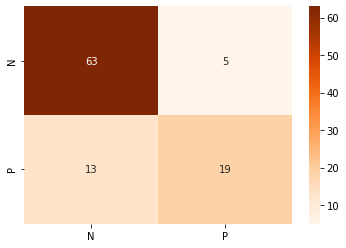

In [45]:
# Display the confusion matrix for our classifier
from sklearn.metrics import confusion_matrix

cm_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['N', 'P'],
    index=['N', 'P']
)
sns.heatmap(cm_df, annot=True,
            cmap='Oranges',)
_ = plt.ylim(2, 0)

### Accuracy/ Zero-One Loss

The idea of the accuracy is to measure how well your model predicted the class of the samples. This correspond to the empirical risk of the model
$$
    Accuracy = \frac{1}{N}\sum_{i=1}^N 1\{\widehat y_i = y_i\} \enspace,
    \quad Error = 1 - Accuracy = \frac{1}{N}\sum_{i=1}^N 1\{\widehat y_i \neq y_i\} \enspace.
$$
It correspond on the probability of correct classification using the classifier.
This is the most common metric used to evaluate a classification task.  
For the confusion matrix $C$, the accuracy is a measure of how close this matrix is from identity $ \frac{\text{Tr}(C)}{N} $

In [46]:
# print("Accuracy: ", (y_pred == y_test).mean())
# print("Score scikit-learn: ", clf.score(X_test, y_test))

In [47]:
# from sklearn.dummy import DummyClassifier
# clf = DummyClassifier('most_frequent')
# clf.fit(X_train,y_train)
# print("Score scikit-learn: ", clf.score(X_test, y_test))

In [48]:
from sklearn.metrics import balanced_accuracy_score

print("Score scikit-learn: ", balanced_accuracy_score(y_test,clf.predict(X_test)))

Score scikit-learn:  0.7601102941176471


However, for imbalanced learning, this metric does not give much information as the fact that the class `1` is badly classified does not show in the accuracy value. This is due to the fact that we consider all class as equal with this metric. To give a better summary of the confusion matrix, one can use metrics designed to highlight the performance for a given class.

### Precision and Recall

The precision and recall are both defined relatively to a chosen positive class.
Precision (also called specificity) is the fraction of relevant instances among the retrieved instances of the positive class, while recall (also known as sensitivity) is the fraction of the total amount of relevant instances of the positive class that were actually retrieved.

<img src="images/precision_recall.png" width="750"/>


These two metrics are computed as
$$
        Precision = \frac{TP}{TP+FP}
        \quad, \quad
        Recall = \frac{TP}{TP+FN} \enspace.
$$
Taking our example back, with positive class `1`, we get

Recall: measure of how many truly relevant results are returned
Precision: quantify, for example how many you predict are going to die among the people who are to going to die



In [49]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
print(f"Precision : {precision}")
print(f"Recall : {recall}")

Precision : 0.7916666666666666
Recall : 0.59375


These two metrics better describe the performance of the classifier, which tends to predict a majority of positive value. We can see in this example that the recall -- *i.e.* the recovery rate of the positive class -- is only at 60% while we have a precision of 80%. This means that our model is conservative. the few examples classified as positive are well chosen but to reach this good precision, we drop a lot of the other positive samples.

It is usefull to note that these two metrics are complementary. They result from a tradeoff between the fact that the predictions are trustworthy (when the model predicts positive, it is confident that it will be true) and the fact that you don't reject too many samples (when a positive sample is presented to the model, it will be predicted as positive). To illustrate this concept, let's consider the limit case:

* If a model always output the negative class, it has a precision of 1 (it never does any mistakes) but it has a recall of 0 as it never find the positive class.
* Inversly, if a model always output the positive class, it has a recall of 1 (all the positive samples are classified as positive) but it as a bad precision (0.5) as all negative samples are also classified as positive. 


### F1 score

The inherent issue with precision and recall is that you can't optimize for both at the same time. As they result of a tradeoff, when you maximize one of the metric, the other will automatically decrease. A convenient way to balance these two metrics is to use the F1-score. This metric combines both the precision and recall and tries to balance both. This score is computed as the geometric mean of the precision $P$ and recall $R$ *i.e.*

$$
    \text{F1-score} = 2 * \frac{P . R}{P + R}\enspace.
$$
The use of a geometric mean permits to give more importance to low scores. Thus, a precision and recall of $(0.8, 0.8)$ will have a larger F1-score compared to $(1, 0.6)$, unlike with arithmetic mean.

In [50]:
from sklearn.metrics import f1_score
print(f"F1-score : {f1_score(y_test, y_pred)}")

F1-score : 0.6785714285714286


This metric is one which is often use for model selection, to ensure a good balance between the precision and recall in the final model.

The classic F1-score give the same weight to the precision and the recall. But it is also possible to change this balance by using a modified f1-score for a given value $\beta > 0$
$$
    \text{F1-score}_\beta =  (1 + \beta^2) * \frac{P . R}{\beta^2 P + R} \enspace .
$$
Setting $\beta = 2$ gives twice as much importance to the recall as to the precision while $\beta = 1/2$ will do the inverse. You can use the slider below to see how the F1-score varies with $\beta$, as a function of precision and recall.

In [51]:
import numpy as np
t = np.linspace(1e-16, 1, 101)
P, R = np.meshgrid(t, t)

def plot_f1(beta):
    F1 = (1 + beta*beta) * (P*R) / (beta*beta*P+R)
    plt.contourf(P, R, F1, 25, cmap='viridis')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.clim([0, 1])
    plt.colorbar()

from ipywidgets import interact, widgets

_ = interact(plot_f1, beta=widgets.FloatLogSlider(
    value=1, min=-1, max=1, step=0.05,
    description='$\\beta$')
)

interactive(children=(FloatLogSlider(value=1.0, description='$\\beta$', max=1.0, min=-1.0, step=0.05), Output(…

### ROC / AUC


Another way to look at the results from our classifier is the ROC curve (Receiver Operating Characteristic). Quoting Wikipedia :

> A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.”

In other words, if the classifier provides a decision function that can be thresholded to control false positives versus false negatives, the ROC curve summarise the different tradeoffs that can be achieved by varying this threshold.

The computation of this curve requires the true labels $y_i$ and the target scores $p_i$, which can either be probability estimates of the positive class, confidence values, or binary decisions. The curve represents the True Positive Rate as a function of the False Positive Rate when varying the decision threshold. In other words, for a decision threshold $\alpha \in [0, 1]$, the ROC curve compute the FPR and TPR of a classifier such that $f(X_i) = 1\{p_i > \alpha)$. A perfect classifier, for which there exist a value $\alpha$ such that all negative samples have a score lower than $\alpha$ and all positive samples have a score higher, would have a ROC curve which would be a step function. With our example, the ROC curve gives:

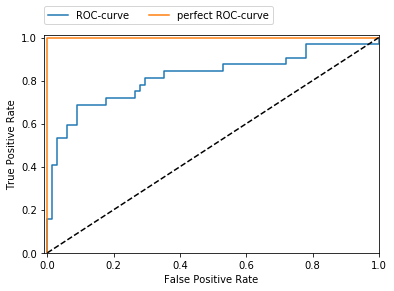

In [52]:
from sklearn.metrics import roc_curve

p_test = clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label=1)
plt.plot(fpr, tpr, label='ROC-curve')
plt.plot([0, 0, 1], [0, 1, 1], label='perfect ROC-curve')
plt.plot(range(0, 2), 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(-0.01, 1)
plt.ylim(0, 1.01)
plt.legend(ncol=2, bbox_to_anchor=(0, 1.05, 1., .3),
           loc=3, borderaxespad=0)

While this curve is convenient to visualize the performance of the classifier, it is usually summarized by the AUC metric which is the area under the ROC curve. This metric scales in $[0, 1]$.

We can use roc_curve for any continuous output.

AUC : 0.8189338235294119


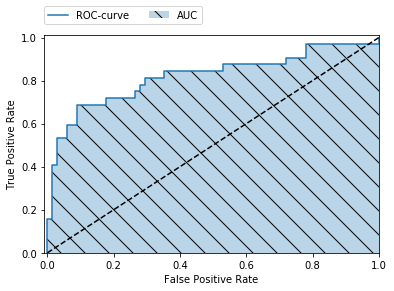

In [9]:
from sklearn.metrics import roc_auc_score

p_test = clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, p_test, pos_label=1)
plt.plot(fpr, tpr, label='ROC-curve')
plt.plot(range(0, 2), 'k--')
plt.fill_between(fpr, tpr, hatch='\\', alpha=0.3, label='AUC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(-0.01, 1)
plt.ylim(0, 1.01)
plt.legend(ncol=2, bbox_to_anchor=(0, 1.05, 1., .3),
           loc=3, borderaxespad=0)

auc = roc_auc_score(y_test, p_test)
print(f"AUC : {auc}")

## Multi-class metrics

Some metrics are essentially defined for binary classification tasks (e.g. F1-score, AUC). In extending a binary metric to multiclass or multilabel problems, the data is treated as a collection of binary problems, one for each class. There are then a number of ways to average binary metric calculations across the set of classes, each of which may be useful in some scenario. Where available, you should select among these using the average parameter.

 * *Macro-average*: simply calculates the mean of the binary metrics, giving equal weight to each class. In problems where infrequent classes are nonetheless important, macro-averaging may be a means of highlighting their performance. On the other hand, the assumption that all classes are equally important is often untrue, such that macro-averaging will over-emphasize the typically low performance on an infrequent class.
 * *Weighted-average*: accounts for class imbalance by computing the average of binary metrics in which each class’s score is weighted by its presence in the true data sample.
 * *Micro-average*: gives each sample-class pair an equal contribution to the overall metric (except as a result of sample-weight). Rather than summing the metric per class, this sums the dividends and divisors that make up the per-class metrics to calculate an overall quotient. Micro-averaging may be preferred in multilabel settings, including multiclass classification where a majority class is to be ignored.

We will see in the second part of the class how imbalanced classes can be handled efficiently.